**Import Libraries**

---



In [8]:
# (OS - CV - NumPy - MAtplotlib - ScikitLearn - TensorFlow)
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Load and Preprocess the Data**

---



In [9]:
# Paths
train_dir = '/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign/Train'
test_csv = '/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign/Test.csv'
test_dir = '/content/GTSRB---German-Traffic-Sign-Recognition/gtsrb-german-traffic-sign/Test'

def load_train_data(train_dir, img_size=(32, 32)):
    images = []
    labels = []
    for label in range(43):
        path = os.path.join(train_dir, str(label))
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

X_train_full, y_train_full = load_train_data(train_dir)

# Split -> train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# One-hot encode labels
num_classes = 43
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

test_df = pd.read_csv(test_csv)
test_images = []
test_labels = []
for idx, row in test_df.iterrows():
    img_path = os.path.join(test_dir, row['Path'].split('/')[-1])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (32, 32))
    img = img / 255.0
    test_images.append(img)
    test_labels.append(row['ClassId'])

X_test = np.array(test_images)
y_test = np.array(test_labels)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (31367, 32, 32, 3), Val shape: (7842, 32, 32, 3), Test shape: (12630, 32, 32, 3)


**Look!**

---



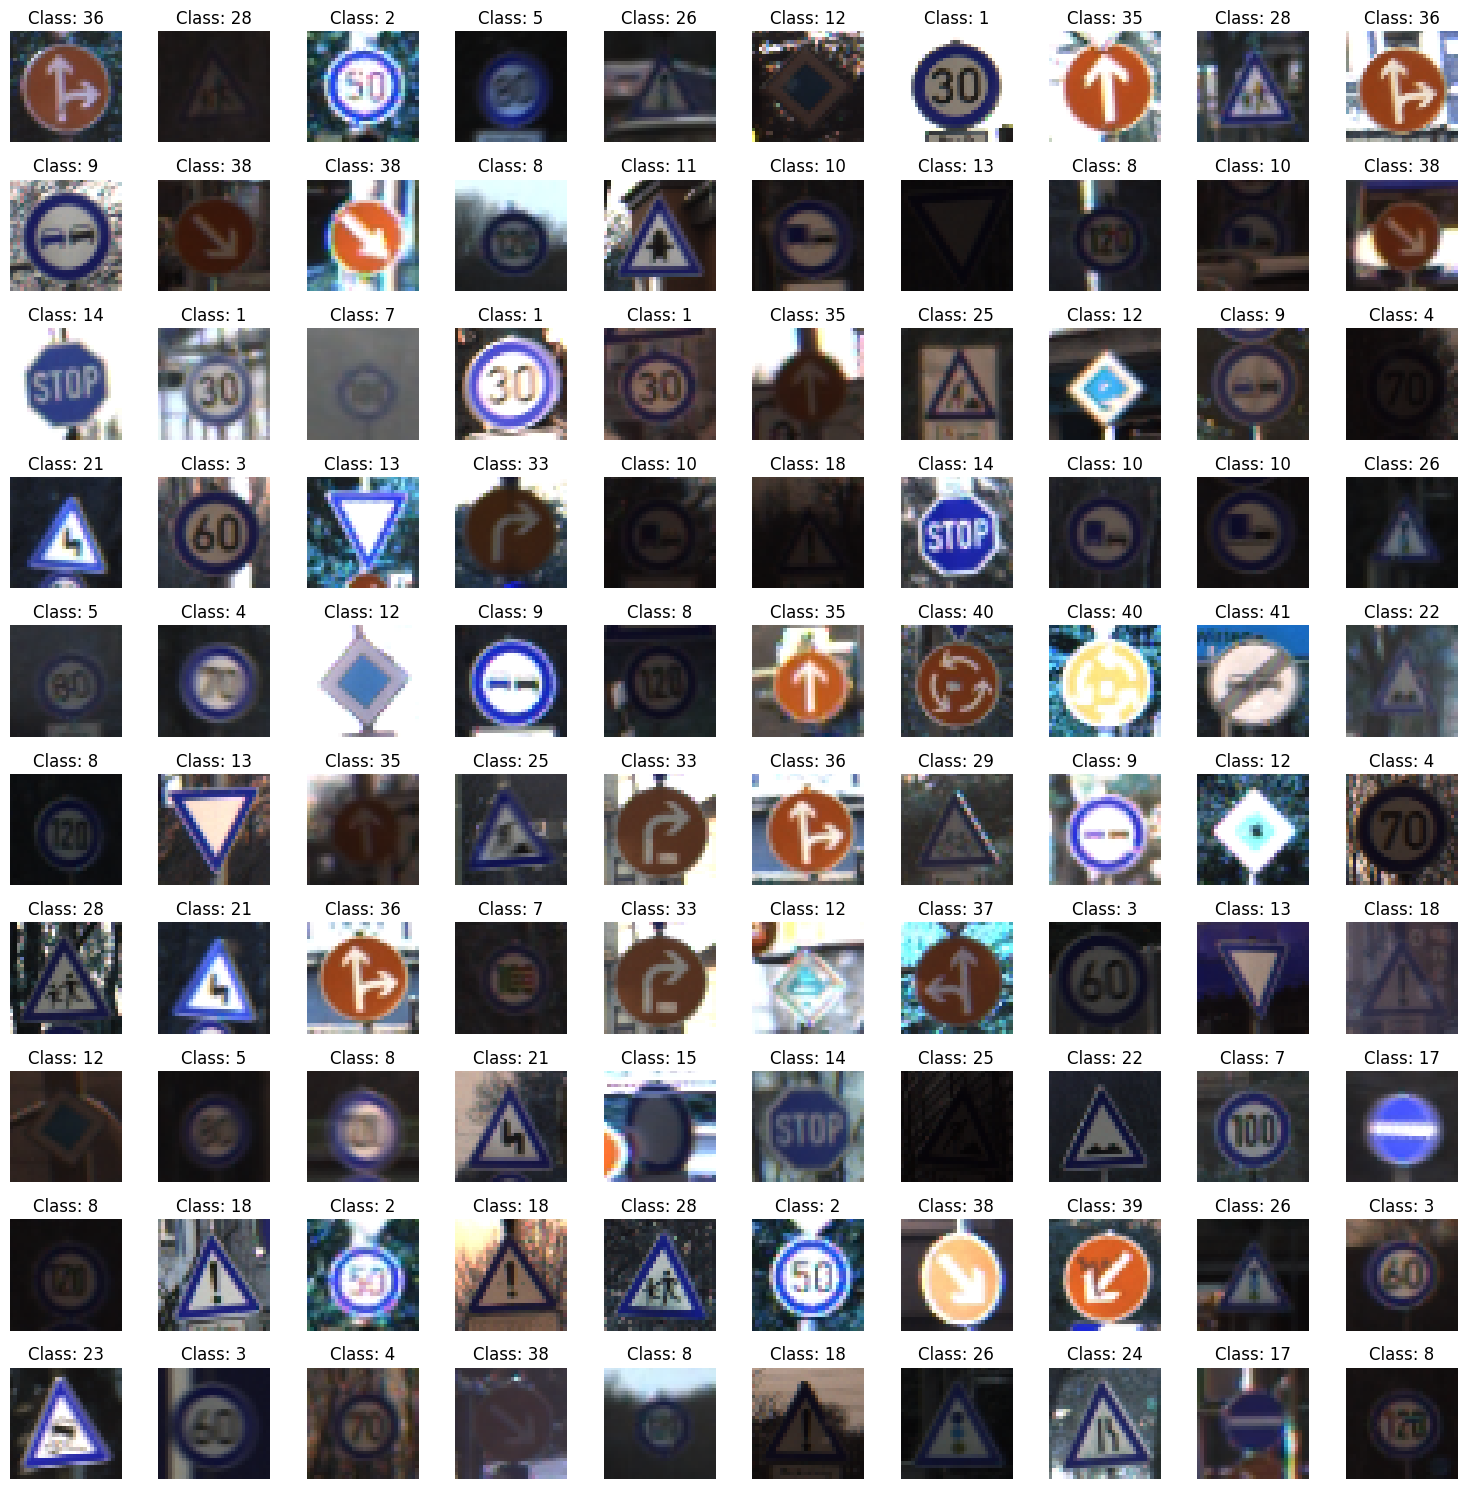

From 0 to 100 (R1)


In [10]:
def display_images_in_batches(images, labels, batch_size=100, batch_number=0, rows=10, cols=10):
    start_idx = batch_number * batch_size
    end_idx = min(start_idx + batch_size, len(images))

    if start_idx >= len(images):
        print("No More!")
        return

    plt.figure(figsize=(15, 15))

    for i, idx in enumerate(range(start_idx, end_idx)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {np.argmax(labels[idx])}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(f"From {start_idx} to {end_idx} (R{batch_number+1})")

# First 100 Of Train
display_images_in_batches(X_train, y_train, batch_size=100, batch_number=0, rows=10, cols=10)

# 100 -> 200
# display_images_in_batches(X_train, y_train, batch_size=100, batch_number=1, rows=10, cols=10)

# Test
# display_images_in_batches(X_test, y_test_cat, batch_size=100, batch_number=0, rows=10, cols=10)

**Build a Custom CNN Model**

---



In [11]:
def build_custom_cnn(input_shape=(32, 32, 3), num_classes=43):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

custom_model = build_custom_cnn()
custom_model.summary()  # View model architecture

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

**Train the Model**

---



In [12]:
history = custom_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.2736 - loss: 2.6516 - val_accuracy: 0.8773 - val_loss: 0.4617
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 82s 49ms/step - accuracy: 0.8369 - loss: 0.5154 - val_accuracy: 0.9667 - val_loss: 0.1277
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 51ms/step - accuracy: 0.9287 - loss: 0.2268 - val_accuracy: 0.9722 - val_loss: 0.0931
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 79s 48ms/step - accuracy: 0.9557 - loss: 0.1427 - val_accuracy: 0.9853 - val_loss: 0.0575
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.9706 - loss: 0.0969 - val_accuracy: 0.9881 - val_loss: 0.0466
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - accuracy: 0.9771 - loss: 0.0753 - val_accuracy: 0.9906 - val_loss: 0.0325
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.9802 - loss: 0.0661 - val_accuracy: 0.9903 - val_loss: 0.0346
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - accuracy: 0.9845 - loss: 0.0530 - 

**Evaluate the Model**

---



In [13]:
test_loss, test_acc = custom_model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9571 - loss: 0.2417
Test Accuracy: 95.34%


**Add Data Augmentation**

---



In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

# Fit generator on training data
datagen.fit(X_train)

# Train with augmentation
history_aug = custom_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                               epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 67s 67ms/step - accuracy: 0.8390 - loss: 0.5844 - val_accuracy: 0.9921 - val_loss: 0.0268
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 65s 66ms/step - accuracy: 0.9292 - loss: 0.2327 - val_accuracy: 0.9925 - val_loss: 0.0239
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - accuracy: 0.9466 - loss: 0.1765 - val_accuracy: 0.9930 - val_loss: 0.0259
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - accuracy: 0.9573 - loss: 0.1377 - val_accuracy: 0.9938 - val_loss: 0.0201
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 64s 65ms/step - accuracy: 0.9663 - loss: 0.1121 - val_accuracy: 0.9929 - val_loss: 0.0213
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 66s 68ms/step - accuracy: 0.9661 - loss: 0.1092 - val_accuracy: 0.9959 - val_loss: 0.0148
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 63s 65ms/step - accuracy: 0.9717 - loss: 0.0939 - val_accuracy: 0.9955 - val_loss: 0.0158
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 64s 66ms/step - accuracy: 0.9725 - loss: 0.0918 - val_accurac

**Compare with Pre-trained Model (MobileNet)**

---



In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_mobilenet(input_shape=(32, 32, 3), num_classes=43):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet()

# Train (with or without augmentation)
history_mob = mobilenet_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate
mob_test_loss, mob_test_acc = mobilenet_model.evaluate(X_test, y_test_cat)
print(f"MobileNet Test Accuracy: {mob_test_acc * 100:.2f}%")

# Compare accuracies
print(f"Custom CNN Accuracy: {test_acc * 100:.2f}% vs. MobileNet: {mob_test_acc * 100:.2f}%")

/tmp/ipython-input-455174594.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.1556 - loss: 3.1250 - val_accuracy: 0.3001 - val_loss: 2.4504
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 39s 40ms/step - accuracy: 0.2649 - loss: 2.5223 - val_accuracy: 0.3249 - val_loss: 2.3008
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.2952 - loss: 2.3891 - val_accuracy: 0.3381 - val_loss: 2.2289
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.3134 - loss: 2.3197 - val_accuracy: 0.3534 - val_loss: 2.1771
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.3236 - loss: 2.2748 - val_accuracy: 0.3633 - val_loss: 2.1357
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 78s 40ms/step - accuracy: 0.3320 - loss: 2.2232 - val_accuracy: 0.3741 - val_loss: 2.0995
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3423 - loss: 2.1872 - val_accuracy: 0.3804 - val_loss: 2.0797
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 4

**Visualization?**

---



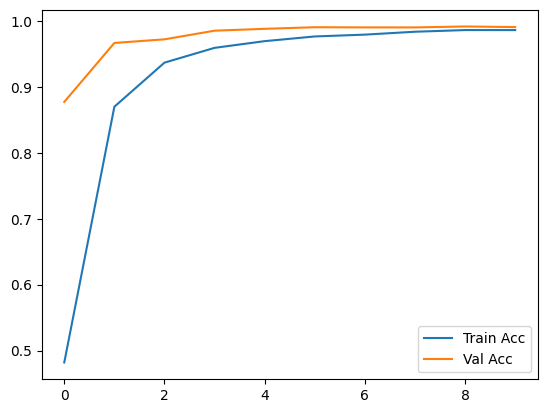

In [16]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()